# Criação de Dataset Artificial
Os passos para gerar o dataset artificial são os seguintes:

1.   Detecção do rosto
2.   Extração da região da imagem correspondente ao rosto
3.   Aplicação de marcos faciais para localizar os olhos, nariz, boca, etc.
4.   Colar a imagem da máscara baseado nos marcos faciais (ao longo do queixo e nariz)

O codigo fonte esta baseado no repositorio da [Prajna Bhandary](https://github.com/prajnasb/observations)


Verificar que o tipo de ambiente de execução é **GPU**.
Para mudar o tipo de ambiente de execução, ir para:

`Ambiente de execução -> Alterar tipo de ambiente de execução`

Em Acelerador de hardware, selecionar **GPU**

## Montar o Drive

Executando as seguinte linhas de codigo, podemos montar nosso Google Drive no Colab:

```python
from google.colab import drive
drive.mount('/content/drive')
```
Depois, um link sera apresentado onde temos que accesar para obter um token. Finalmente temos que colar o token nosso Colab para permitir o acceso ao nossos arquivos.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My\ Drive/Colabs/Mask_Detection

/content/drive/My Drive/Colabs/Mask_Detection


## Instalar Dependencias

Neste caso, só vamos precisar da biblioteca [face-recognition](https://pypi.org/project/face-recognition/) para fazer a detecção de rostos e extrair os marcos faciais.


```
!pip install -U face-recognition
```



In [3]:
!pip install -U face-recognition

     |████████████████████████████████| 100.2MB 113kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=a8942c93f3871c88689649467b63540b742fd21eb6c189a167795c30f96bbf7b
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


##Import das bibliotecas necessarias

In [18]:
import os
from os import mkdir
from os.path import splitext,join,basename,exists
import numpy as np
from PIL import Image, ImageFile
from glob import glob
from natsort import natsorted

## Código Principal

### Classe **FaceMasker**
Esta classe faz a leitura da imagem e a máscara que sera aplicada, obtem os marcos faciais e baseado na localização do queixo e nariz transforma a máscara para excaixar ela no rosto.

In [19]:
class FaceMasker:
    KEY_FACIAL_FEATURES = ('nose_bridge', 'chin')

    def __init__(self, face_path, mask_path, prefix_path, show=False, model='cnn'):
        self.face_path = face_path
        self.prefix_path = prefix_path
        self.face_mask_path = self._get_new_path()
        self.mask_path = mask_path

        self.show = show
        self.model = model
        self._face_img: ImageFile = None
        self._mask_img: ImageFile = None

    def mask(self):
        import face_recognition

        face_image_np = face_recognition.load_image_file(self.face_path)
        face_locations = face_recognition.face_locations(face_image_np, model=self.model)
        face_landmarks = face_recognition.face_landmarks(face_image_np, face_locations)
        self._face_img = Image.fromarray(face_image_np)
        self._mask_img = Image.open(self.mask_path)

        found_face = False
        for face_landmark in face_landmarks:
            # check whether facial features meet requirement
            skip = False
            for facial_feature in self.KEY_FACIAL_FEATURES:
                if facial_feature not in face_landmark:
                    skip = True
                    break
            if skip:
                continue

            # mask face
            found_face = True
            self._mask_face(face_landmark)

        if found_face:
            if self.show:
                self._face_img.show()
            # save
            self._save()
        else:
            print('Found no face.')
                
    def _mask_face(self, face_landmark: dict):
        nose_bridge = face_landmark['nose_bridge']
        nose_point = nose_bridge[len(nose_bridge) * 1 // 4]
        nose_v = np.array(nose_point)

        chin = face_landmark['chin']
        chin_len = len(chin)
        chin_bottom_point = chin[chin_len // 2]
        chin_bottom_v = np.array(chin_bottom_point)
        chin_left_point = chin[chin_len // 8]
        chin_right_point = chin[chin_len * 7 // 8]

        # split mask and resize
        width = self._mask_img.width
        height = self._mask_img.height
        width_ratio = 1.2
        new_height = int(np.linalg.norm(nose_v - chin_bottom_v))

        # left
        mask_left_img = self._mask_img.crop((0, 0, width // 2, height))
        mask_left_width = self.get_distance_from_point_to_line(chin_left_point, nose_point, chin_bottom_point)
        mask_left_width = int(mask_left_width * width_ratio)
        mask_left_img = mask_left_img.resize((mask_left_width, new_height))

        # right
        mask_right_img = self._mask_img.crop((width // 2, 0, width, height))
        mask_right_width = self.get_distance_from_point_to_line(chin_right_point, nose_point, chin_bottom_point)
        mask_right_width = int(mask_right_width * width_ratio)
        mask_right_img = mask_right_img.resize((mask_right_width, new_height))

        # merge mask
        size = (mask_left_img.width + mask_right_img.width, new_height)
        mask_img = Image.new('RGBA', size)
        mask_img.paste(mask_left_img, (0, 0), mask_left_img)
        mask_img.paste(mask_right_img, (mask_left_img.width, 0), mask_right_img)

        # rotate mask
        angle = np.arctan2(chin_bottom_point[1] - nose_point[1], chin_bottom_point[0] - nose_point[0])
        rotated_mask_img = mask_img.rotate(angle, expand=True)

        # calculate mask location
        center_x = (nose_point[0] + chin_bottom_point[0]) // 2
        center_y = (nose_point[1] + chin_bottom_point[1]) // 2

        offset = mask_img.width // 2 - mask_left_img.width
        radian = angle * np.pi / 180
        box_x = center_x + int(offset * np.cos(radian)) - rotated_mask_img.width // 2
        box_y = center_y + int(offset * np.sin(radian)) - rotated_mask_img.height // 2

        # add mask
        self._face_img.paste(mask_img, (box_x, box_y), mask_img)

    def _get_new_path(self):
        path_splits = splitext(basename(self.face_path))
        new_face_path = "{}-with-mask{}".format(path_splits[0], path_splits[1])
        return join(self.prefix_path, new_face_path)

    def _save(self):        
        self._face_img.save(self.face_mask_path)
        print(f'Save to {self.face_mask_path}')

    @staticmethod
    def get_distance_from_point_to_line(point, line_point1, line_point2):
        distance = np.abs((line_point2[1] - line_point1[1]) * point[0] +
                          (line_point1[0] - line_point2[0]) * point[1] +
                          (line_point2[0] - line_point1[0]) * line_point1[1] +
                          (line_point1[1] - line_point2[1]) * line_point1[0]) / \
                   np.sqrt((line_point2[1] - line_point1[1]) * (line_point2[1] - line_point1[1]) +
                           (line_point1[0] - line_point2[0]) * (line_point1[0] - line_point2[0]))
        return int(distance)

### Função para aplicar as máscaras

In [20]:
def add_mask(image_path, mask_path, prefix_path):
    pic_path = image_path    
    show = False
    model = "hog"
    FaceMasker(pic_path, mask_path, prefix_path, show, model).mask()

Vamos definir uma pasta que contem as imagens e outra onde vamos salvar as imagens modificadas com a mascara.

```python
mask_path = "blue-mask.png"
faces_folder = "faces"
masks_folder = "faces_mask"

if not exists(masks_folder):
  mkdir(masks_folder)
```

Geramos uma lista com os nomes de todas as imagens
```python
list_faces_path = glob(join(faces_folder,"*.jpg"))
```

E iteramos sobre a lista de imagens, aplicando a mascara em cada imagem
```python
for face_path in list_faces_path:
  add_mask(face_path, mask_path, masks_folder)
```



In [21]:
mask_path = "blue-mask.png"
faces_folder = "faces"
masks_folder = "faces_mask"

if not exists(masks_folder):
  mkdir(masks_folder)

list_faces_path = glob(join(faces_folder,"*.jpg"))
list_faces_path = natsorted(list_faces_path, key=lambda y: y.lower())

for face_path in list_faces_path:
  add_mask(face_path, mask_path, masks_folder)

Save to faces_mask/face_input_0-with-mask.jpg
Save to faces_mask/face_input_1-with-mask.jpg
Save to faces_mask/face_input_2-with-mask.jpg


## Visualização


Geramos uma lista com as máscaras aplicadas:
```python
list_masks_path = glob(join(masks_folder,"*.jpg"))
```
Agora vamos iterar sobre as imagens e as máscaras:
```python
for face_path, mask_path in zip(list_faces_path,list_masks_path):   
```
Fazemos a leitura da imagem e sua respectiva máscara:
```python
  face_image = cv2.imread(face_path,1)
  face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

  mask_image = cv2.imread(mask_path,1)
  mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
```
Finalmente mostramos cada um para visualizar os resultados
```python
  plt.figure(figsize=(10,10))

  plt.subplot(121)
  plt.imshow(face_image)
  plt.title("Imagem Original")
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(mask_image)
  plt.title("Imagem com Máscara")
  plt.axis("off")

  plt.show()
```



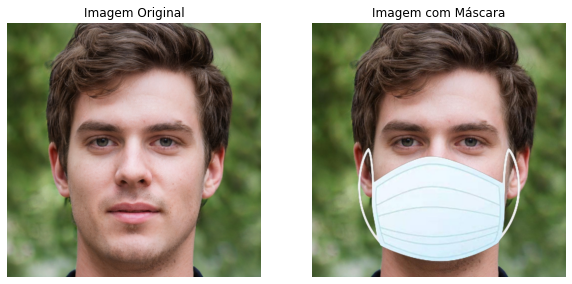

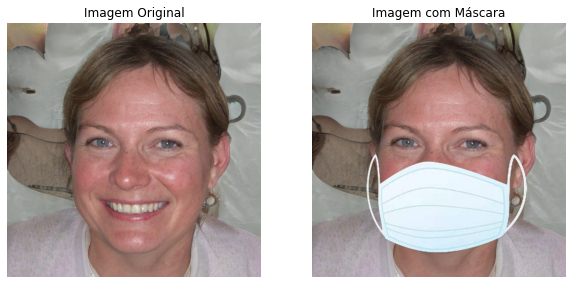

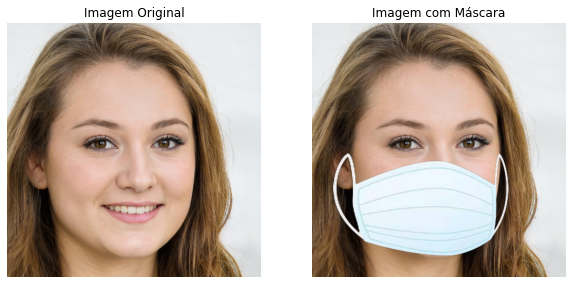

In [22]:
import cv2
import matplotlib.pyplot as plt

list_masks_path = glob(join(masks_folder,"*.jpg"))
list_masks_path = natsorted(list_masks_path, key=lambda y: y.lower())

for face_path, mask_path in zip(list_faces_path,list_masks_path):   
  face_image = cv2.imread(face_path,1)
  face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

  mask_image = cv2.imread(mask_path,1)
  mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)

  plt.figure(figsize=(10,10))

  plt.subplot(121)
  plt.imshow(face_image)
  plt.title("Imagem Original")
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(mask_image)
  plt.title("Imagem com Máscara")
  plt.axis("off")

  plt.show()

## Visualização de Marcos Faciais

### Visualização do Rosto

Fazemos a detecção do rosto na imagem:
```python
image = face_recognition.load_image_file("faces/face_input_0.jpg")
face_locations = face_recognition.face_locations(image)
```
Agora extraimos o rosto usando as coordenadas obtidas:
```python
face_location = face_locations[0]
top, right, bottom, left = face_location
face_image = image[top:bottom, left:right]
```



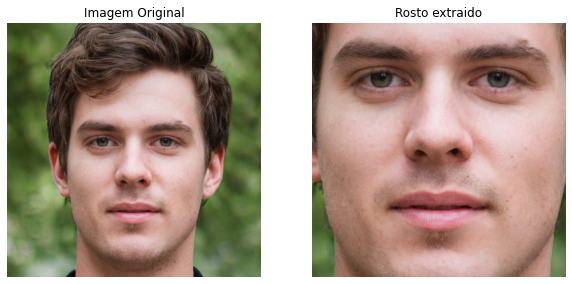

In [23]:
from PIL import Image
import face_recognition

image = face_recognition.load_image_file("faces/face_input_0.jpg")
face_locations = face_recognition.face_locations(image)

face_location = face_locations[0]
top, right, bottom, left = face_location
face_image = image[top:bottom, left:right]
pil_image = Image.fromarray(face_image)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(image)
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(122)
plt.imshow(pil_image)
plt.title("Rosto extraido")
plt.axis('off')

plt.show()

### Visualização dos Marcos Faciais

Baseado na posição do rosto, podemos extrair os marcos faciais:
```python
face_landmarks = face_recognition.face_landmarks(image, face_locations)
```
Finalmente, podemos iterar nas coordenadas de cada marco facial para visualizar eles:
```python
for landmark,color in zip(landmarks_keys,colors):
  landmark_points = np.asarray(face_landmarks[0][landmark])
  plt.scatter(landmark_points[:,0],landmark_points[:,1],color=color)
```



dict_keys(['chin', 'left_eyebrow', 'right_eyebrow', 'nose_bridge', 'nose_tip', 'left_eye', 'right_eye', 'top_lip', 'bottom_lip'])


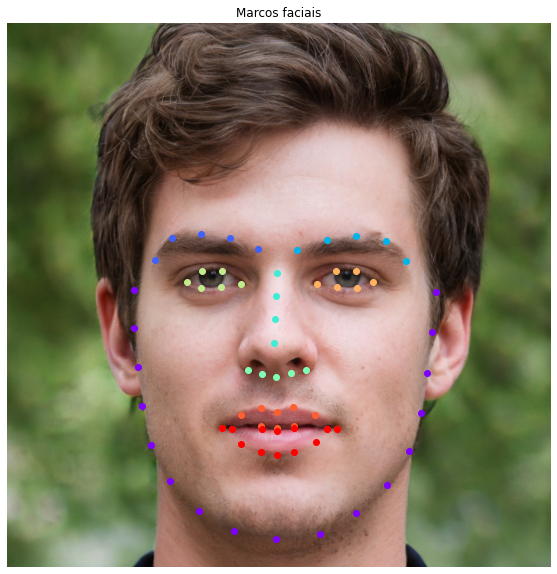

In [24]:
import matplotlib.cm as cm

face_landmarks = face_recognition.face_landmarks(image, face_locations)
landmarks_keys = face_landmarks[0].keys()
print(landmarks_keys)

colors = cm.rainbow(np.linspace(0, 1, len(landmarks_keys)))

plt.figure(figsize=(10,10))
plt.imshow(image)

for landmark,color in zip(landmarks_keys,colors):
  landmark_points = np.asarray(face_landmarks[0][landmark])
  plt.scatter(landmark_points[:,0],landmark_points[:,1],color=color)

plt.title("Marcos faciais")
plt.axis("off")
plt.show()